In [271]:
#Import des csv

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm



I) On va d'abord traite les données afin de pouvoir les utiliser correctement par la suite.

In [272]:
crypto_prices = pd.read_csv("crypto_prices_v2.csv")
# Convert timestamp column to datetime format
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])

# Set timestamp column as index
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices.head()

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,bid-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,0.013622,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,0.013083,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,0.014231,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,0.013833,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,0.012865,705.739433,0.608839,1.199186


In [273]:
exchange_info = pd.read_csv("exchange_info_v2.csv")
exchange_info.head()

,Unnamed: 0,CeX,DeX
0,unfi-busd,1,0
1,iota-usd,1,0
2,bhp-usdt,1,0
3,dot-usdt,1,0
4,aave-usdt,1,0


In [274]:
crix = pd.read_csv("crix.csv", delimiter=";")
crix['date'] = pd.to_datetime(crix['date'])
crix.head()


C:\Users\alanm\AppData\Local\Temp\ipykernel_29240\4172023063.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  crix['date'] = pd.to_datetime(crix['date'])


,date,price
0,2014-07-31,1000
1,2014-08-01,"1018,202717"
2,2014-08-02,"1008,772389"
3,2014-08-03,"1004,4165"
4,2014-08-04,"1004,984138"


In [275]:
data_factors = pd.read_csv("data_factors.csv", delimiter=";", header=4)
data_factors = data_factors.rename(columns={data_factors.columns[0]: 'timestamp'})
data_factors = data_factors.iloc[:-1]
# Convert timestamp column to datetime format
data_factors['timestamp'] = pd.to_datetime(data_factors['timestamp'])
data_factors.head()




,timestamp,Mkt-RF,SMB,HML,RF
0,1926-07-01,"0,1","-0,25","-0,27","0,009"
1,1926-07-02,"0,45","-0,33","-0,06","0,009"
2,1926-07-06,"0,17","0,3","-0,39","0,009"
3,1926-07-07,"0,09","-0,58","0,02","0,009"
4,1926-07-08,"0,21","-0,38","0,19","0,009"


In [276]:
momentum_daily = pd.read_csv("momentum_daily.csv", delimiter=";", header=13)
momentum_daily.fillna(0, inplace=True)
momentum_daily = momentum_daily.iloc[:, :-2]

# Convert date column to timestamp format
momentum_daily = momentum_daily.rename(columns={momentum_daily.columns[0]: 'timestamp'})
momentum_daily = momentum_daily.iloc[:-2]
momentum_daily['timestamp'] = pd.to_datetime(momentum_daily['timestamp'])

On implemente GetPortfolioCompo

In [277]:

rebalancing_dates = pd.date_range(start=crypto_prices.index.min(), end=crypto_prices.index.max(), freq='MS')
rebalancing_dates = rebalancing_dates[1:]
def get_portfolio_compo(df, rebalancing_dates, portfolio_index, horizon):
    portfolio_data = []
    
    for date in rebalancing_dates:
        portfolios = {}
        for i in range(portfolio_index):
            # Sélectionner les données de marché pour la date de rééquilibrage
            market_data = df.loc[date]
            
            # Calculer les rendements sur l'horizon spécifié
            returns = (market_data - df.shift(periods=horizon).loc[date]) / df.shift(periods=horizon).loc[date]
            
            # Classer les cryptomonnaies en fonction des rendements décroissants
            ranked_cryptos = returns.sort_values(ascending=False)
            
            # Extraire les noms des cryptomonnaies pour le portefeuille i+1
            portfolio = ranked_cryptos.iloc[i * 10: (i + 1) * 10]
            
            # Ajouter les noms et les rendements des cryptomonnaies au portefeuille
            portfolio_with_returns = [crypto_name for crypto_name, return_value in portfolio.items()]
            portfolios[f"Portfolio_{i+1}"] = portfolio_with_returns
            
        portfolio_data.append(portfolios)
    
    # Créer un DataFrame à partir des données de portefeuille
    portfolio_df = pd.DataFrame(portfolio_data, index=rebalancing_dates)
    
    return portfolio_df

# Supposons que vous voulez le portefeuille P1 à chaque date de rééquilibrage avec un horizon de 1 jour
portfolios_df = get_portfolio_compo(crypto_prices, rebalancing_dates, portfolio_index=9, horizon=15)

print(portfolios_df)

                                                  Portfolio_1  \
2021-02-01  [fund-usdt, doge-usdt, 1inch-usdt, gala-usdt, ...   
2021-03-01  [ersdl-usdt, matic-usdt, senso-usdt, pol-usdt,...   
2021-04-01  [storj-usd, steem-usdt, winx-usdt, win-usdt, b...   
2021-05-01  [pol-usdt, senso-usdt, ersdl-usdt, matic-usdt,...   
2021-06-01  [nmc-usdt, hnt-usdt, matic-usdt, hex-usdt, cel...   
2021-07-01  [fund-usdt, albt-usdt, strong-usdt, bid-usdt, ...   
2021-08-01  [ersdl-usdt, gala-usdt, hegic-usdt, sc-usdt, l...   
2021-09-01  [kp3r-usdt, strong-usdt, avax-usdt, sol-usdt, ...   
2021-10-01  [nmc-usdt, strong-usdt, atom-usdt, hex-usdt, a...   
2021-11-01  [mana-busd, sand-usdt, senso-usdt, bid-usdt, c...   
2021-12-01  [gala-usdt, sand-usdt, tncc-usdt, plu-usd, sto...   
2022-01-01  [sushi-usd, sushi-usdt, atom-usdt, kp3r-usdt, ...   
2022-02-01  [plu-usd, xor-usdt, wxt-usdt, snx-usdt, tusd-u...   
2022-03-01  [api3-usdt, atom-usdt, nmc-usdt, mx-usdt, unfi...   
2022-04-01  [jst-usdt, sr

On implemente UpdateValue, UpdateCompo et ComputePortfolioValue


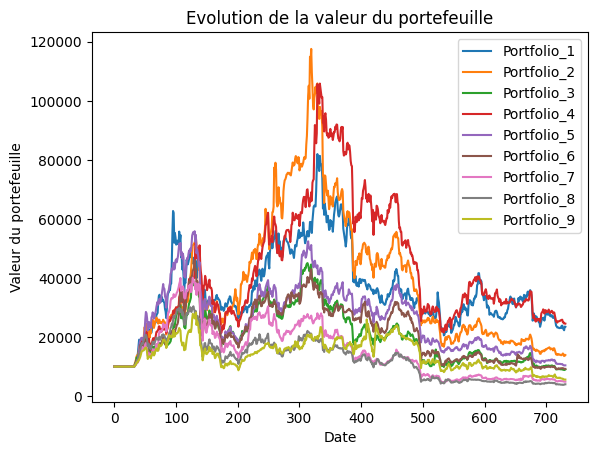

In [278]:
def UpdateValue(date, crypto_prices, portfolio_compo, initial_value):
    if len(portfolio_compo) == 0:
        return initial_value
    portfolio_value = (crypto_prices.loc[date, list(portfolio_compo.keys())] * list(portfolio_compo.values())).sum()
    return portfolio_value


def UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices):
    portfolio_compo.clear()
    portefeuille_actuelle = portfolios_df.loc[date, f"Portfolio_{portfolio_index}"]
    portfolio_compo.update({crypto_name: portfolio_value / (10 * crypto_prices.loc[date, crypto_name]) for crypto_name in portefeuille_actuelle})


def compute_portfolio_values(crypto_prices, rebalancing_dates, portfolio_index, horizon, initial_value):
    portfolio_compo = {}
    portfolio_values = [initial_value]
    portfolio_value = initial_value

    for date in crypto_prices.index:
        portfolio_value = UpdateValue(date, crypto_prices, portfolio_compo, initial_value)
        if date in rebalancing_dates:
            UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices)
        portfolio_values.append(portfolio_value)

    return portfolio_values


# Initialiser la valeur initiale du portefeuille
initial_portfolio_value = 10000  # Par exemple, 10000 USD

# Indices de portefeuille à considérer
portfolio_indices = range(1, 10)

# Calculer les valeurs des portefeuilles pour les dates de rééquilibrage
portfolio_values_dict = {}

for portfolio_index in portfolio_indices:
    portfolio_values = compute_portfolio_values(crypto_prices, rebalancing_dates, portfolio_index, horizon=15, initial_value=initial_portfolio_value)
    portfolio_values_dict[f"Portfolio_{portfolio_index}"] = portfolio_values

# Afficher les graphiques pour chaque indice de portefeuille
for portfolio_index, portfolio_values in portfolio_values_dict.items():
    plt.plot(portfolio_values, label=portfolio_index)

plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()
plt.show()




Nous allons mettre en place le portefeuille P1-9.

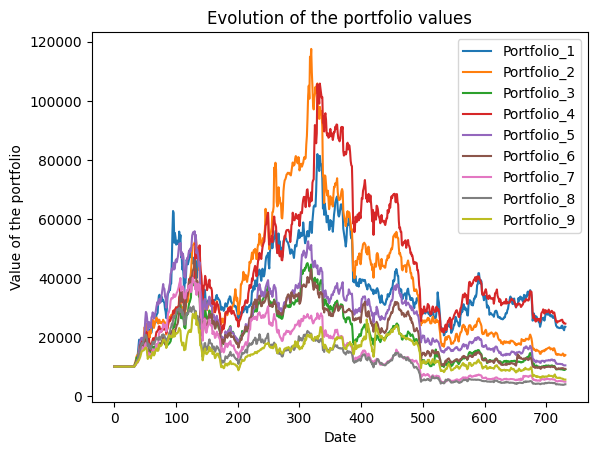

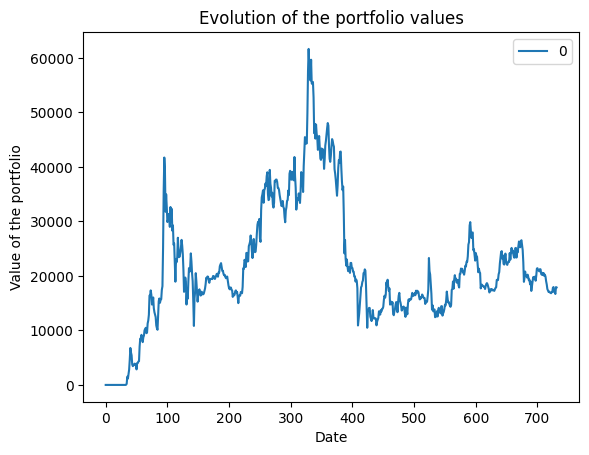

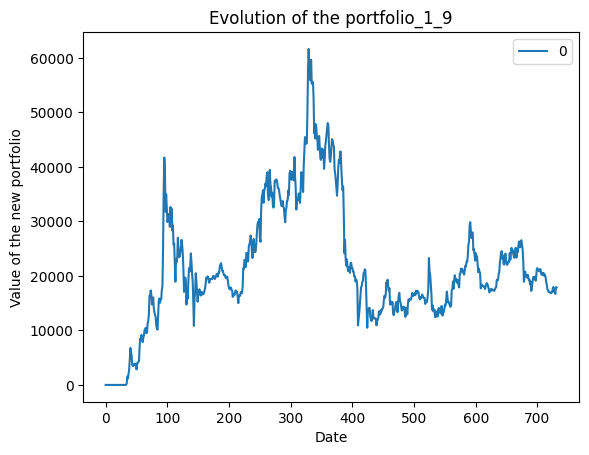

In [279]:
# Get the values of Portfolio 1 and the last portfolio
portfolio_1_values = portfolio_values_dict["Portfolio_1"]
last_portfolio_values = portfolio_values_dict[f"Portfolio_{len(portfolio_values_dict)}"]

# Create a new portfolio that buys Portfolio 1 and sells the last portfolio
portfolio_1_9 = pd.Series(portfolio_1_values) - pd.Series(last_portfolio_values)
#on convertit portfolio_1_9 en dataframe
portfolio_1_9 = pd.DataFrame(portfolio_1_9)
# Plot the values of all portfolios
portfolio_values_df = pd.DataFrame(portfolio_values_dict)
portfolio_values_df.plot(title='Evolution of the portfolio values', xlabel='Date', ylabel='Value of the portfolio')

# Plot the new portfolio values
portfolio_1_9.plot(label="Portfolio long 1 short 9")
plt.title('Evolution of the portfolio values')
plt.xlabel('Date')
plt.ylabel('Value of the portfolio')
plt.legend()
plt.show()

# Plot the new portfolio values P1_9
portfolio_1_9.plot(title='Evolution of the portfolio_1_9', xlabel='Date', ylabel='Value of the new portfolio')
plt.show()


On affiche les daily returns des differents portfolio en prenant bien soin de supprimer les NA.

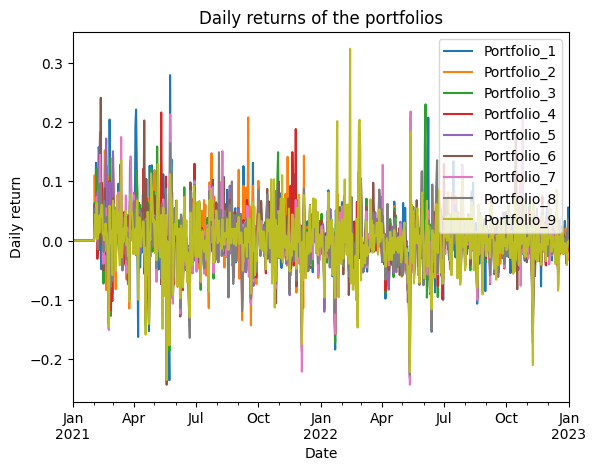

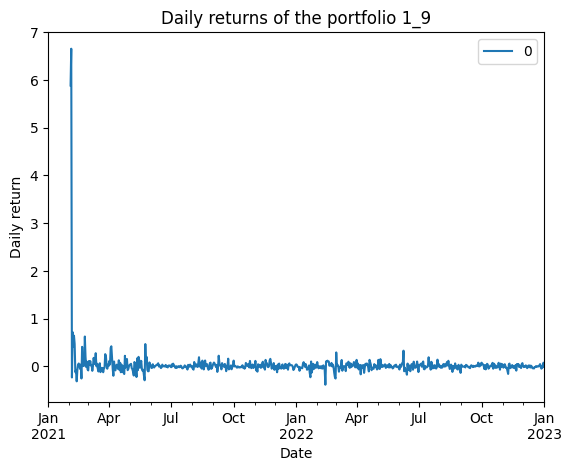

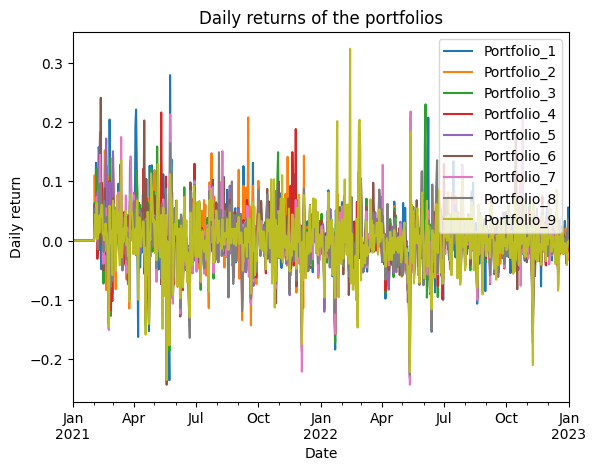

In [280]:
#on drop les nan
portfolio_values_df = portfolio_values_df.dropna()
#on drop la premiere ligne de portfolio_values_df
portfolio_values_df = portfolio_values_df.iloc[1:]
#on rajoute les timestamp de crypto_prices comme index de portfolio_values_df
portfolio_values_df.index = crypto_prices.index


portfolio_daily_returns = portfolio_values_df.pct_change()
portfolio_daily_returns.plot(title='Daily returns of the portfolios', xlabel='Date', ylabel='Daily return')
plt.show()

portfolio_1_9 = portfolio_1_9.iloc[1:]
portfolio_1_9.index = crypto_prices.index
portfolio_1_9_daily_returns = portfolio_1_9.pct_change()
portfolio_1_9_daily_returns.plot(title='Daily returns of the portfolio 1_9', xlabel='Date', ylabel='Daily return')
plt.show()
#on affiche les daily return de chaque portfolio par groupe de 3
portfolio_values_df.pct_change().plot(title='Daily returns of the portfolios', xlabel='Date', ylabel='Daily return')
plt.show()


In [281]:
# Get the first and last dates from data_factors
first_date = data_factors['timestamp'].min()
last_date = crypto_prices.index.max()

# Create a DataFrame with all dates between the first and last date
all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates})

# Merge rf_df with data_factors on timestamp using a left join
rf_df = rf_df.merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')

# Forward fill missing RF values
rf_df['RF'].fillna(method='ffill', inplace=True)
#on convertit RF en float
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)

# Print the DataFrame for the date '2021-01-03'
print(rf_df[rf_df['timestamp'] == '2021-01-03'])

# Merge the portfolio values with the risk-free rate
merged_df = portfolio_daily_returns.merge(rf_df, left_index=True, right_on='timestamp', how='left')
merged_df.set_index('timestamp', inplace=True)
merged_df.tail()

#on fait la meme chose pour portfolio 1_9
rf_df_1_9 = pd.DataFrame({'timestamp': all_dates})
rf_df_1_9 = rf_df_1_9.merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df_1_9['RF'].fillna(method='ffill', inplace=True)
rf_df_1_9['RF'] = rf_df_1_9['RF'].str.replace(',', '.').astype(float)
merged_df_1_9 = portfolio_1_9_daily_returns.merge(rf_df_1_9, left_index=True, right_on='timestamp', how='left')
merged_df_1_9.set_index('timestamp', inplace=True)  

       timestamp   RF
34520 2021-01-03  0.0


C:\Users\alanm\AppData\Local\Temp\ipykernel_29240\3565195189.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rf_df['RF'].fillna(method='ffill', inplace=True)
C:\Users\alanm\AppData\Local\Temp\ipykernel_29240\3565195189.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_df['RF'].fillna(method='ffill', inplace=True)
C:\Users\alanm\AppData\Local\Temp\ipykernel_29240\3565195189.py:28: FutureWarning: A value is trying to be set on a c

In [282]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
sharpe_ratios_portfolios = (portfolio_daily_returns.mean() - merged_df['RF'].mean()) / portfolio_daily_returns.std()
sharpe_ratios_1_9 = (portfolio_1_9_daily_returns.mean() - merged_df_1_9['RF'].mean()) / portfolio_1_9_daily_returns.std()

0    inf
dtype: float64


C:\Users\alanm\AppData\Roaming\Python\Python39\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
